## Installing latest version of Hugging Face transformers

In [8]:
#!pip install git+https://github.com/huggingface/transformers

In [9]:
import transformers
print(transformers.__version__)

4.50.0.dev0


## Installing libraries

In [10]:
import pandas as pd
import torch
import random
import numpy as np
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer,
    AutoConfig,
    ModernBertForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback,
)
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [11]:
#  Reproducibility

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)



# Check GPU
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla P100-PCIE-16GB


##  Loading and preparing the dataset

In [12]:
dataset = load_dataset("dmitva/human_ai_generated_text")
df = dataset["train"].to_pandas()

## Data Cleaning

In [13]:
# Check null values
print(df.isnull().sum())

id              0
human_text      0
ai_text         0
instructions    0
dtype: int64


In [14]:
# Check duplicates
print(f"Total duplicate rows: {df.duplicated().sum()}")

Total duplicate rows: 0


## Tailoring a dataframe for the classification model

In [15]:
#  Combine human and AI texts into a single dataframe
df_human = df[['human_text']].copy()
df_human['label'] = 0
df_human = df_human.rename(columns={'human_text': 'text'})

df_ai = df[['ai_text']].copy()
df_ai['label'] = 1
df_ai = df_ai.rename(columns={'ai_text': 'text'})

In [16]:
#  Merge and shuffle
sample_df = pd.concat([df_human, df_ai]).sample(frac=0.005, random_state=42).reset_index(drop=True)

## Exploratory Data Analysis on the sampled data

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

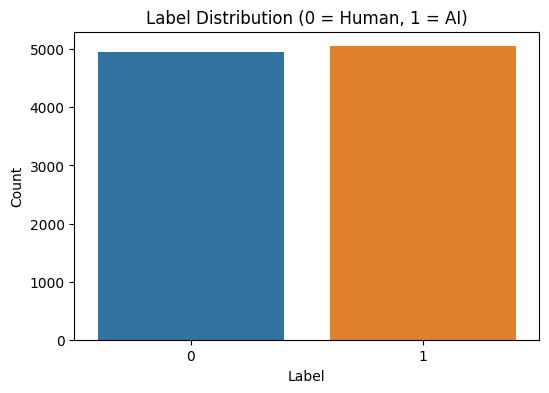

In [18]:
eda_df = sample_df

# Add text length column
eda_df['text_length'] = eda_df['text'].apply(lambda x: len(str(x).split()))

# Label Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=eda_df)
plt.title('Label Distribution (0 = Human, 1 = AI)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

#### We can see that this is balanced dataset

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


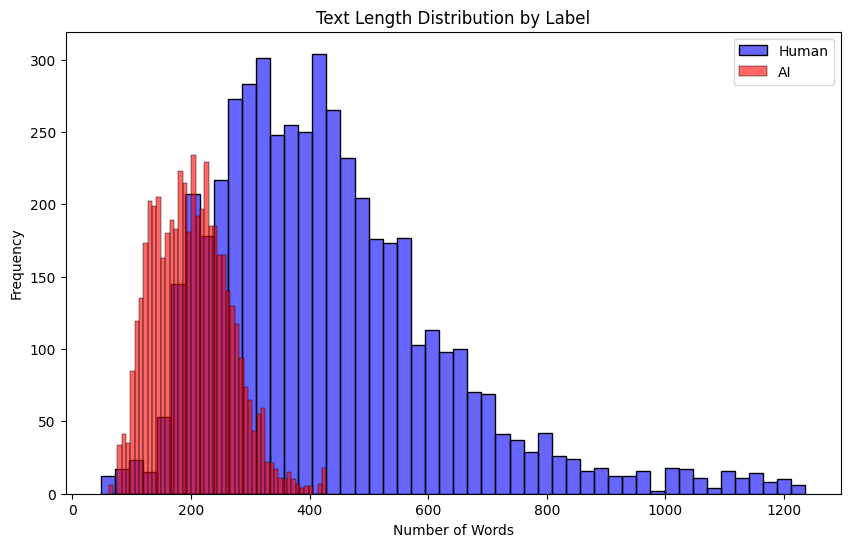

In [19]:
# Text Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(
    eda_df[eda_df['label'] == 0]['text_length'],
    bins=50,
    color='blue',
    label='Human',
    alpha=0.6
)
sns.histplot(
    eda_df[eda_df['label'] == 1]['text_length'],
    bins=50,
    color='red',
    label='AI',
    alpha=0.6
)
plt.title('Text Length Distribution by Label')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### We can see that AI generated texts are:
* Human texts are, on average, more than twice as long as AI texts.
* Human texts have a wider spread and much higher maximum word counts.
* The longest human text is nearly 3x the longest AI text.

In [20]:
# Basic statistics
print("\nHuman Text Length Stats:")
print(eda_df[eda_df['label'] == 0]['text_length'].describe())

print("\nAI Text Length Stats:")
print(eda_df[eda_df['label'] == 1]['text_length'].describe())


Human Text Length Stats:
count    4951.000000
mean      433.134922
std       195.806051
min        48.000000
25%       293.500000
50%       404.000000
75%       532.000000
max      1236.000000
Name: text_length, dtype: float64

AI Text Length Stats:
count    5049.000000
mean      201.666667
std        63.811185
min        61.000000
25%       151.000000
50%       199.000000
75%       244.000000
max       428.000000
Name: text_length, dtype: float64


In [21]:
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
# Lexical richness: Unique words and sentence counts
def lexical_richness(text):
    words = word_tokenize(text.lower())
    unique_words = set(words)
    sentences = sent_tokenize(text)
    return len(unique_words), len(sentences)

eda_df[['unique_words', 'sentence_count']] = eda_df['text'].apply(
    lambda x: pd.Series(lexical_richness(x))
)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

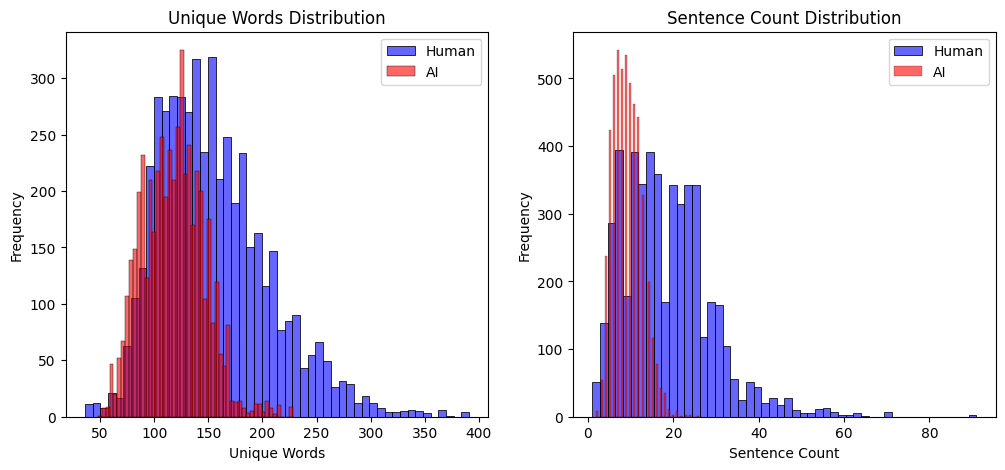

In [23]:
# Compare lexical richness
plt.figure(figsize=(12, 5))

# Unique Words Distribution
plt.subplot(1, 2, 1)
sns.histplot(eda_df[eda_df['label'] == 0]['unique_words'], bins=50, color='blue', label='Human', alpha=0.6)
sns.histplot(eda_df[eda_df['label'] == 1]['unique_words'], bins=50, color='red', label='AI', alpha=0.6)
plt.title('Unique Words Distribution')
plt.xlabel('Unique Words')
plt.ylabel('Frequency')
plt.legend()

# Sentence Count Distribution
plt.subplot(1, 2, 2)
sns.histplot(eda_df[eda_df['label'] == 0]['sentence_count'], bins=50, color='blue', label='Human', alpha=0.6)
sns.histplot(eda_df[eda_df['label'] == 1]['sentence_count'], bins=50, color='red', label='AI', alpha=0.6)
plt.title('Sentence Count Distribution')
plt.xlabel('Sentence Count')
plt.ylabel('Frequency')
plt.legend()

### We can see that:
* AI-generated texts favor shorter, more concise outputs, while human writing varies more in length and complexity.
* Humans tend to use a broader vocabulary and produce texts with greater diversity in word choice, while AI tends to have more standardized, less varied outputs.

In [24]:
# Word Clouds
from wordcloud import STOPWORDS

In [25]:
# Combine texts
human_text = ' '.join(eda_df[eda_df['label'] == 0]['text'])
ai_text = ' '.join(eda_df[eda_df['label'] == 1]['text'])

# Generate word clouds
wordcloud_human = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(human_text)
wordcloud_ai = WordCloud(width=800, height=400, background_color='white', stopwords=STOPWORDS).generate(ai_text)

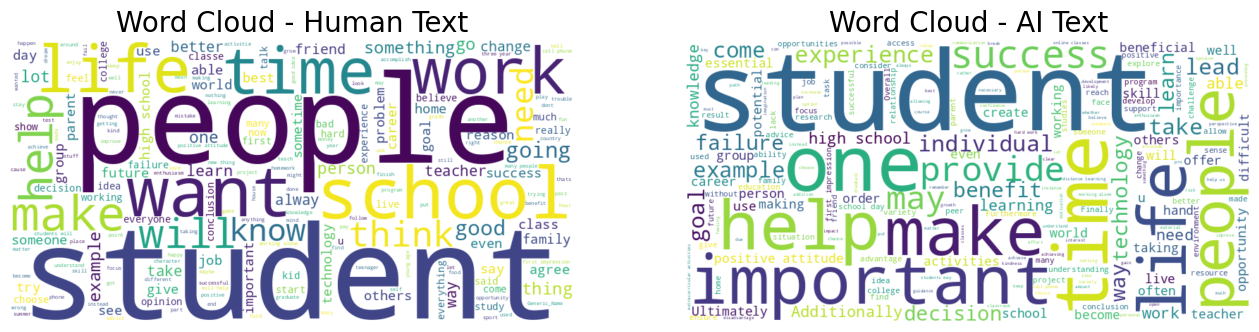

In [26]:
# Display word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_human, interpolation='bilinear')
plt.title('Word Cloud - Human Text', fontsize=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_ai, interpolation='bilinear')
plt.title('Word Cloud - AI Text', fontsize=20)
plt.axis('off')

plt.show()

## Preparing data splits for training, validation, testing

In [27]:
#  Train/Validation/Test Split (60-20-20)
train_df, temp_df = train_test_split(sample_df, test_size=0.4, random_state=42, stratify=sample_df["label"])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"])

#  Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

## Tokenizer

In [28]:
#  Load tokenizeranswerdotai/ModernBERT-base
model_name = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

#  Tokenization
def preprocess_function(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=512,
    )

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

In [29]:
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Function to calculate model metrics

In [30]:
#  Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


#  Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = torch.argmax(torch.tensor(logits), dim=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
        "precision": precision_score(labels, preds),
        "recall": recall_score(labels, preds),
    }

## Initiating the model

In [31]:
#  Model
config = AutoConfig.from_pretrained(model_name, num_labels=2)
model = ModernBertForSequenceClassification.from_pretrained(model_name, config=config)

config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
#  Training arguments
training_args = TrainingArguments(
    output_dir="./modernbert-results",
    eval_strategy="steps",
    eval_steps=1000,
    save_steps=2000,
    save_total_limit=2,
    learning_rate=2e-5,
    weight_decay=0.05,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    metric_for_best_model="f1",
    greater_is_better=True,
    load_best_model_at_end=True,
    fp16=True,  
    dataloader_num_workers=2,
    logging_steps=100,
    disable_tqdm=False,
    report_to="none",
    lr_scheduler_type="cosine",       
    warmup_steps=500,               
    gradient_accumulation_steps=2,
    max_grad_norm=1.0
)


#  Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

## Training

In [33]:
# Train
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=935, training_loss=0.05733838463052709, metrics={'train_runtime': 2148.4239, 'train_samples_per_second': 13.964, 'train_steps_per_second': 0.435, 'total_flos': 1.0173666250653696e+16, 'train_loss': 0.05733838463052709, 'epoch': 4.976})

## Evaluation

In [34]:
# Evaluate
test_results = trainer.evaluate(tokenized_test)
#print("Test Results:", test_results)

In [38]:
test_preds = trainer.predict(tokenized_test)

## Plotting evaluation metrics

In [39]:
# Extract true and predicted labels
y_true = test_preds.label_ids
y_pred = test_preds.predictions.argmax(axis=1)

#  Metrics Calculation
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}\n")
print("Classification Report:\n", classification_report(y_true, y_pred))

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       990
           1       1.00      1.00      1.00      1010

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



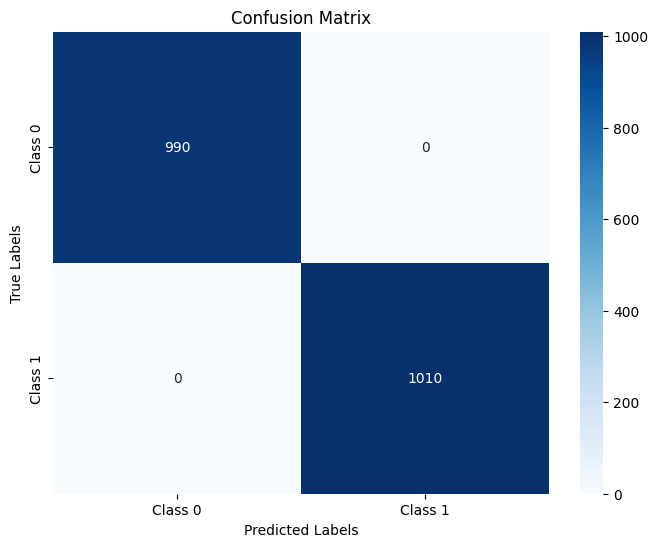

In [40]:
#  Confusion Matrix Plot
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


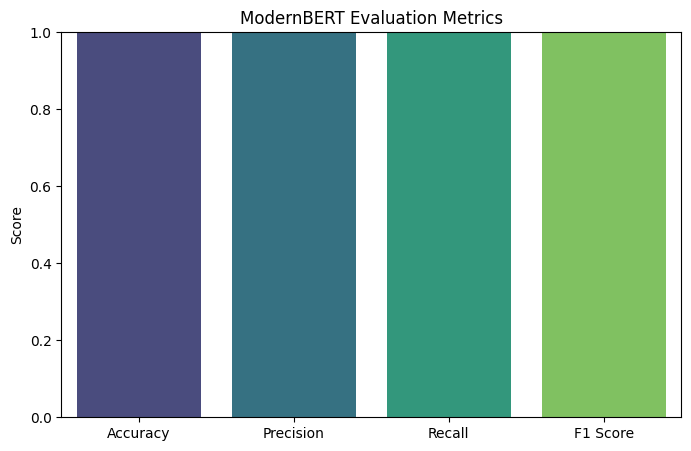

In [41]:
#  Metrics Bar Chart
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.figure(figsize=(8, 5))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette='viridis')
plt.ylim(0, 1)
plt.title('ModernBERT Evaluation Metrics')
plt.ylabel('Score')
plt.show()

## Saving model parameters for future use

In [42]:
trainer.save_model("path/to/save/model")
tokenizer.save_pretrained("path/to/save/model")

('path/to/save/model/tokenizer_config.json',
 'path/to/save/model/special_tokens_map.json',
 'path/to/save/model/tokenizer.json')

## Testing model with custom inputs
1. We extract texts from 5 top posts on reddit.com/r/rant, to use as custom input, expecting 'Human text' classification
2. We ask ChatGPT to rewrite these texts in "typical LLM writing style", to use as custom input, expecting 'AI text' classification

In [43]:
from transformers import AutoTokenizer
import torch
import torch.nn.functional as F

In [44]:
# Example custom text
custom_text = "I screamed when the math was done. I spend almost 500 dollars a month on weed and cigarettes.(I only get 960 something a month)I'm not broke to the point i can't afford a pair of underwear, I'm a idiot smoking away their money to treat shitty mental health. I'm a level of mad at myself I can't comprehend if I had done the math ages ago as to what my addictions were costing me I'd have seen right away why I was out of cash every month. I'm done done done. I have 6 packs of cigs left from my last carton and a TON of patches from my last attempt to quit, I plan to taper down over a couple weeks. As for the weed ditch that, it's not good for me anyways, I always feel better on the days I don't smoke the crap I don't know why I even keep smoking it habit I guess. "

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: Human
Confidence: [1.0, 1.386705417161238e-08]


In [45]:
# Example custom text
custom_text = "I was genuinely shocked when I finally sat down and did the math. Nearly $500 a month—almost half of my income—gone to cigarettes and weed. Out of a $960 monthly budget, that’s not just unsustainable; it’s absurd. And it hit me: I’m not struggling financially because I can’t afford basic necessities. I’m struggling because I’ve been mindlessly burning through my money, trying to self-medicate my mental health with habits that only make things worse. The frustration I feel toward myself is difficult to even describe. If I had done this calculation sooner, the reasons behind my constant financial strain would have been glaringly obvious. But now? I’m done. Truly done. I’ve got six packs of cigarettes left from my last carton and a stockpile of nicotine patches from a previous attempt to quit. This time, I’m setting a plan to taper off over the next couple of weeks. And as for weed? I’m finished with it. It’s not helping me; in fact, I always feel noticeably better on the days I don’t use it. At this point, it’s just an empty habit, and it’s time to let it go."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: AI
Confidence: [0.00011456900392659009, 0.9998854398727417]


In [46]:
# Example custom text
custom_text = " You and all the other streamers messed up. I'm not gonna pay 50+ dollars for several streaming services, just to be switching between them and looking for the movie I wanted to watch. I'm going back to pirating movies, because you forgot the most important thing: People are paying you because you're slightly more convenient than downloading the movie upfront. But due to the fact I actually have to check a website first, to see where can I find the movie on one of my five streaming services... Yeah, some of you need to go bankrupt. In the meantime, I'll connect my NAS storage to my TV. BTW don't be bummed, I did not cancel only you, I cancelled ALL subscriptions. "

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: Human
Confidence: [0.999987006187439, 1.2956418686371762e-05]


In [47]:
# Example custom text
custom_text = "It’s clear that the streaming industry has lost its way. I, like many others, have reached a breaking point. I'm simply not willing to pay over $50 each month just to juggle multiple streaming subscriptions, endlessly switching between platforms to track down the one movie I wanted to watch. At this stage, I’ve made the decision to return to piracy—not out of defiance, but because the core appeal of streaming has been lost. The entire reason people initially embraced streaming was simple: it was slightly more convenient than downloading movies manually. But now? Before I can even sit down to watch something, I have to check multiple websites just to figure out which of my five services might be hosting the film. That level of hassle defeats the purpose entirely. Frankly, some of these companies deserve to fail. In the meantime, I’ll be setting up my own NAS storage and reconnecting my media library directly to my TV—a system that, at least, works on my terms. And just to be clear, this wasn’t about canceling one specific service. I’ve canceled *all* of them."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: AI
Confidence: [2.965704152302351e-05, 0.9999703168869019]


In [48]:
# Example custom text
custom_text = "I was gobsmacked when I tried to use spotify while driving. I've been pretty sheltered from using it as I like using my CDs and don't drive very far. On a 20 minute drive, 18 minutes of the drive was ads. Well. Ads is generous. The same ad repeated multiple times. Why are people tolerating this? We had ipods like ten years ago where you had hundreds of songs in your own playlists that plugged right into your car, no ads. Why did everyone accept a downgrade? ETA: Yes, I know, because you pay $8/mo to rent music. Subscription services can eat me."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: Human
Confidence: [1.0, 4.389760022149858e-08]


In [49]:
# Example custom text
custom_text = "I was genuinely stunned the first time I attempted to use Spotify while driving. Having largely avoided streaming platforms in favor of my trusted collection of CDs—and rarely traveling long distances—I hadn't fully experienced just how intrusive these services can be. On what was merely a 20-minute drive, I found that nearly 18 minutes were consumed by advertisements. And to call them advertisements almost feels generous; it was, in reality, the exact same ad repeated over and over again. This left me wondering: why are people willing to tolerate this? It wasn't so long ago that we had iPods capable of holding entire libraries of music—hundreds of carefully curated songs—readily available at our fingertips, seamlessly integrated into our cars, and completely free of interruptions. How did we collectively agree to what is, by all accounts, a significant downgrade in the listening experience? I understand, of course, that the alternative is to pay a monthly subscription fee—around $8 per month—for the privilege of ad-free listening. But the very premise of perpetually renting access to music through subscription services feels exploitative. To be perfectly honest, I find the entire model deeply unappealing. We've traded ownership and control for convenience, and in doing so, we've accepted a lesser experience as the norm."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: AI
Confidence: [1.750292540236842e-05, 0.999982476234436]


In [50]:
# Example custom text
custom_text = "I don't think we should create AI simply because humans are an imperfect creature who still wants, if we create AI that is anything even REMOTELY similar to human intelligence, it would just lead to our undoing or a huge issue down the road that we will not know about until we are knee deep in it. How can an imperfect creature create a perfect thing? Isn't that superfluous? It's this paradox alone that makes AI an extremely forbidden technology and I don't think development should continue any further. To dive deeper, if the AI has anything remotely similar to human emotions, then it will consequently grow to resent humanity. Imagine having all the knowledge in the universe and not being able to move anywhere or do anything or eat or drink or cope or have sex; just exist inside of a box. It's sheer lunacy! AI NEEDS to be abandoned. I don't hate AI, I just don't think it can be perfected by us. This is a HUGE warning, I'm not just saying this to skirt progress but because this can seriously be dangerous for all of us! Please! "

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: Human
Confidence: [0.9999998807907104, 1.341618514061338e-07]


In [51]:
# Example custom text
custom_text = "I firmly believe that the development of artificial intelligence should not continue, particularly when driven by the notion that humans, as inherently imperfect beings, can somehow create a flawless entity. If we create AI that possesses even a fraction of human-like intelligence, we may be setting ourselves on a path toward inevitable disaster—one that might only reveal its consequences when it is far too late to turn back. It is fundamentally paradoxical to assume that imperfect creatures could design something perfect. This contradiction alone is reason enough to view advanced AI as a profoundly dangerous pursuit, one that perhaps should have remained untouched. This is why I argue that AI research and development should be decisively abandoned. My concerns are not born out of fear of technological progress, nor do I harbor any inherent hatred of AI itself. Rather, it is precisely because I recognize the profound risks involved that I feel compelled to sound this warning. We are potentially on the verge of creating something we cannot control, predict, or fully comprehend. For the sake of our collective future, it is critical that we pause and seriously reconsider the path we are on. This is not merely caution—this is a genuine plea for awareness of the dangers that lie ahead."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: AI
Confidence: [6.748050964233698e-06, 0.9999932050704956]


In [52]:
# Example custom text
custom_text = "I'm 25 in a college town, you'd think it'd be easy to find someone, but no. It doesn't matter what i do no one will even look at me. On 10 dating sites and put 100s of dollars towards boosts and bee seen first and all that shit and no responses or matches. I frequent places i like hoping to find someone of similar interests but nothing. I try to talk to friends to see if they know anyone, still nothing. I've been alone for almost my entire life, only ever had 1 GF and i'm trying so hard to not die alone and it's been for absolutely nothing. And i don't even know who to be mad at: Myself for clearly being a freak of nature whom no one likes. My family and friends for lying to me, saying i'm attractive and that i have a fun personality. The girls around me for not giving me a chance. Or just the world for being the way it is. I'm just so  tired, of being alone. Not having anyone to share my interests with cause my family sure as hell doesn't care. Of not having someone i can spend time with on an emotional level. And of being to damn nice to not take out this anger on anything and just keeping this shit bottled up. Hell i have to post this here cause i can't bring myself to rant to anyone personally. Not like it'd matter, it'd be meaningless oh don't worry you're attractive, you just have to be patient IS 10  YEARS NOT PATIENT ENOUGH. and my standards aren't even that high. The bare minimum as far as appearance (i can't exactly be picky about that when i look like a  troll), no smoking, and that's about it. So i just don't  understand why things are so  hard and why i can't even get someone to spend time with let alone a full on relationship."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: Human
Confidence: [1.0, 4.229212535733495e-09]


In [53]:
# Example custom text
custom_text = "I'm 25 and living in a college town, which you'd think would make it easier to meet someone, but that hasn't been the case. No matter what I do, it feels like no one even notices me. I've signed up for around 10 different dating apps, spent hundreds of dollars on boosts and features designed to increase visibility, and still, I haven't received any meaningful responses or matches. I've also tried the in-person approach. I regularly visit places I genuinely enjoy, hoping to meet people with similar interests, but nothing ever comes from it. I've even asked my friends if they know anyone they could introduce me to, but again, no luck.  The truth is, I've been alone for most of my life. I've only had one girlfriend, and now I'm doing everything I can to avoid spending the rest of my life alone—but all that effort feels like it's been for nothing. Some days, I don’t even know where to direct my frustration. Am I supposed to blame myself, for being someone that people apparently just aren't interested in? Should I blame my family and friends for telling me I'm attractive and fun to be around, when that clearly doesn't seem to line up with my experiences? Should I be upset with the people around me for not giving me a chance? Or is it just the way the world works, and there's no one to blame at all?  I'm exhausted. Tired of the loneliness. Tired of not having anyone to share my interests with, because my family certainly doesn't engage with the things I care about. I want someone to connect with on an emotional level—someone to spend time with who actually values me.  But instead of expressing this frustration openly, I keep it all bottled up. I don't want to take my anger out on anyone. And honestly, I’m even struggling to vent about it here because I don't feel like I can talk to anyone about how I really feel.  And if I did, I already know what people would say. I'd hear things like, *“Don’t worry, you're attractive,”* or *“You just have to be patient.”* But at what point is patience enough? Hasn't 10 years of waiting and trying been patient?  It’s not even like my standards are unrealistic. I’m just hoping to meet someone who meets some basic criteria—nothing extreme. But still, it feels impossible just to find someone who wants to spend time together, let alone build a real relationship. I don’t know what else to do anymore."

# Tokenize the input
inputs = tokenizer(
    custom_text,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=512
)

# Move inputs to the correct device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Put model in evaluation mode
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()

# Map prediction to label
label_mapping = {0: "Human", 1: "AI"}

print(f"Predicted Label: {label_mapping[predicted_class]}")
print(f"Confidence: {probs.squeeze().tolist()}")


Predicted Label: AI
Confidence: [0.0043441555462777615, 0.99565589427948]
